In [101]:
import numpy as np
from scipy.constants import c, e, m_p, epsilon_0, m_e
from joblib import Parallel, delayed
import sys

import PyHEADTAIL
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems, RFBucket
from PyHEADTAIL.impedances.wakes import WakeField, WakeTable, ResistiveWall, CircularResistiveWall
from PyHEADTAIL.particles import slicing
from tqdm import tqdm

from helper_funcs import *

In [102]:
import seaborn as sbs
sbs.set(rc={'figure.figsize':(8.3,5.2),
            'text.usetex':True,
           'font.family':'serif',
            'text.usetex': True,
           'axes.linewidth':1.2,
           'lines.linewidth':3,
           },
        style='ticks',
        palette='colorblind',
        context='talk', 
       font_scale=1.2) 
sbs.set_style('ticks',
               {
                'grid.linestyle': 'none',
                'axes.edgecolor': '0',
                'axes.linewidth': 1.2, 
               })
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

### Defining some constants

In [103]:
np.random.seed(42)                            # Random seed (for particle distribution generation)
n_turns = 2049                                # Number of turns in the synchrotron
n_turns_slicemonitor = 2048                   # Number of turns to monitor motion withing the bunch
n_macroparticles = int(10**5)                 # Number of macroparticles in a single bunch
intensity = 5e10                              # Number of real particles
### 'Granularity' would be intensity/n_macroparticles
n_segments = 1                                # NUmber of segme nts for tranverse tracking
Ekin = 11.4e6                                 # Energy of the reference particle
gamma = 1 + Ekin * e / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
R = C / (2.*np.pi)
C = 216.72                                    # Accelerator circumference
A = 238                                       # Atomic mass number
Z = 28                                        # Charge number
Q_x = 4.2                                     # Number of horizontal oscillations per turn
Q_y = 3.4                                     # Number of vertical oscillations per turn
gamma_t = 4.9                                 # Relativistic gamma of transition energy
alpha_0 = [gamma_t**-2]                       # Momentum compaction factor
alpha_x_inj = 0.                              # Twiss alpha function 
alpha_y_inj = 0.
beta_x_inj = C/(2*np.pi*Q_x)                  # Twiss beta function
beta_y_inj = C/(2*np.pi*Q_y)
sigma_z = 4
epsn_x = 12.5e-6  # [m rad]
epsn_y = 12.5e-6  # [m rad]
phi = 0 if (gamma**-2-gamma_t**-2) < 0 else np.pi #Synchronous phase
h_rf = 4                                      # RF harmonic

In [104]:
p0 = np.sqrt(gamma**2 - 1) * A * m_p * c
s = np.arange(0, n_segments + 1) * C / n_segments
alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)
alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)

egeox = epsn_x / (beta * gamma)
egeoy = epsn_y / (beta * gamma)

### Defining longitudinal tracking

In [105]:
long_map = RFSystems(C, [h_rf, ], [16e3, ], [phi, ],
                     alpha_0, gamma, mass=A*m_p, charge=Z*e)
print(
    'The resulting number of longitudinal oscillations \n a single particle makes in a single turn: {0:.3f}'.format(
    long_map.Q_s))

The resulting number of longitudinal oscillations 
 a single particle makes in a single turn: 0.007


### The resulting RF bucket

In [86]:
rfb = RFBucket(C, gamma, A*m_p, Z*e, alpha_0, 0., [4], [16e3], [phi])
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
# zz = np.linspace(2*rfb.z_left, 2*rfb.z_right, num=1000)
zz = np.linspace(0, C, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*2.1, dpmax*2.1, num=500))
hh = rfb.hamiltonian(Z, DP, make_convex=True)

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  


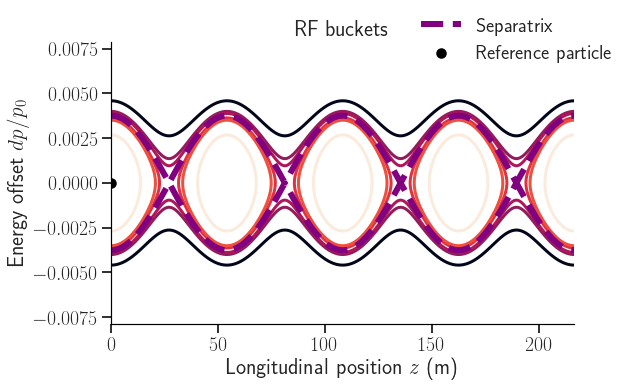

In [87]:
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.contour(Z, DP, hh, levels=[-150, -40, -20, 20, 40, 150], label=None)

ax.plot(zz, rfb.separatrix(zz), c='purple', lw=6, linestyle='dashed', label='Separatrix')
ax.plot(zz, -rfb.separatrix(zz), c='purple', lw=6, linestyle='dashed', label=None)
z0 = rfb.z_sfp # longitudinal position of the reference particle
ax.scatter(z0, 0, label='Reference particle', marker='o', color='black')
ax.title.set_text('RF buckets')
ax.set_xlabel('Longitudinal position $z$ (m)')
ax.set_ylabel('Energy offset $dp/p_0$')
plt.figlegend(frameon=False, loc='upper right')

### Generating bunches (number of bunches is set to the RF harmonic)

In [106]:
bunches = [generators.ParticleGenerator(macroparticlenumber=n_macroparticles, intensity=intensity, charge=Z*e,
                                        gamma=gamma, mass=A*m_p, circumference=C,
                                        distribution_x=generators.gaussian2D(egeox), alpha_x=alpha_x, beta_x=beta_x,
                                        distribution_y=generators.gaussian2D(egeoy), alpha_y=alpha_y, beta_y=beta_y,
                                        limit_n_rms_x=3.5, limit_n_rms_y=3.5,
                                        distribution_z=generators.RF_bucket_distribution(
                                            long_map.get_bucket(gamma=gamma), sigma_z=sigma_z)
                                        ).generate() for i in range(h_rf)]
for n, bunch in enumerate(bunches):
    bunch.z[:] += (n*C/h_rf)
allbunches = bunches[0]
for b in bunches[1:]:
    allbunches+=b
    

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


... distance to target bunch length: -3.9513e+00
... distance to target bunch length: 4.3035e+00
... distance to target bunch length: 3.4105e+00
... distance to target bunch length: 7.7342e-01
... distance to target bunch length: -3.3603e-01
... distance to target bunch length: -3.7220e-03
... distance to target bunch length: 2.2915e-05
... distance to target bunch length: -2.2778e-09
... distance to target bunch length: -3.9513e+00
... distance to target bunch length: 4.3035e+00
... distance to target bunch length: 3.4105e+00
... distance to target bunch length: 7.7342e-01
... distance to target bunch length: -3.3603e-01
... distance to target bunch length: -3.7220e-03
... distance to target bunch length: 2.2915e-05
... distance to target bunch length: -2.2778e-09
... distance to target bunch length: -3.9513e+00
... distance to target bunch length: 4.3035e+00
... distance to target bunch length: 3.4105e+00
... distance to target bunch length: 7.7342e-01
... distance to target bunch le

### Looking how bunch fits into the bucket

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  


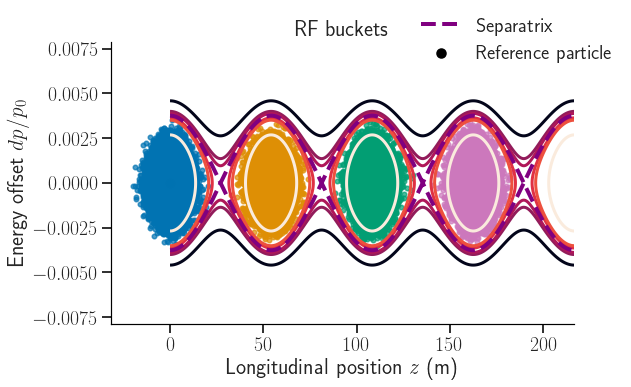

In [93]:
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.contour(Z, DP, hh, levels=[-150, -40, -20, 20, 40, 150], label=None)

ax.plot(zz, rfb.separatrix(zz), c='purple', lw=4, linestyle='dashed', label='Separatrix')
ax.plot(zz, -rfb.separatrix(zz), c='purple', lw=4, linestyle='dashed', label=None)
z0 = rfb.z_sfp # longitudinal position of the reference particle
ax.scatter(z0, 0, label='Reference particle', marker='o', color='black')
###COLORS
palette = sbs.color_palette('colorblind')
### BUNCH 1
bunch1 = bunches[0]
bunch_z = bunch1.z
bunch_dp = bunch1.dp
ax.scatter(bunches[0].z, bunches[0].dp, marker='.', alpha=0.05, color=palette[0])
### BUNCH2
ax.scatter(bunches[1].z, bunches[1].dp, marker='.', alpha=0.05, color=palette[1])
### BUNCH3
ax.scatter(bunches[2].z, bunches[2].dp, marker='.', alpha=0.05, color=palette[2])
### BUNCH4 
ax.scatter(bunches[3].z, bunches[3].dp, marker='.', alpha=0.05, color=palette[4])
### ALL BUCNHES TOGETHER
# ax.scatter(allbunches.z, allbunches.dp, marker='.', alpha=0.7, c='black')

ax.title.set_text('RF buckets')
ax.set_xlabel('Longitudinal position $z$ (m)')
ax.set_ylabel('Energy offset $dp/p_0$')
plt.figlegend(frameon=False, loc='upper right')

### Introducing a wakefield element

In [136]:
n_wake_slices = 500                                                         ### Number of slices for the wakefield interaction
z_cuts = (-4.2*bunches[0].sigma_z(), 3*C/h_rf+4.2*bunches[-1].sigma_z())    ### Range of the slices
print('Wake slicer range: ({0:.3f}, {1:.3f})'.format(z_cuts[0], z_cuts[1]))
wake_slicer = slicing.UniformBinSlicer(                                     ### Slicer used to separate particles based on their longitudinal positions
    n_slices=n_wake_slices, z_cuts=z_cuts)
dt_min = C/c/n_wake_slices                                                  ### Minimal time step
res_wall = CircularResistiveWall(pipe_radius=5e-2,                        ### Radius of the accelerator pipe
                                  resistive_wall_length=3*C,                ### Length of the accelerator pipe
                                  dt_min=dt_min,                            ### Timestep
                                  conductivity=1.4e6)                       ### Conductivity of the accelerator pipe 

wake_field = WakeField(wake_slicer, res_wall)
print(wake_field.wake_kicks[0])
print(res_wall.get_wake_kicks(wake_slicer)[0])

Wake slicer range: (-16.743, 179.310)


### How does a wake kick look like for the first turn:

Text(0, 0.5, 'Wake kick ')

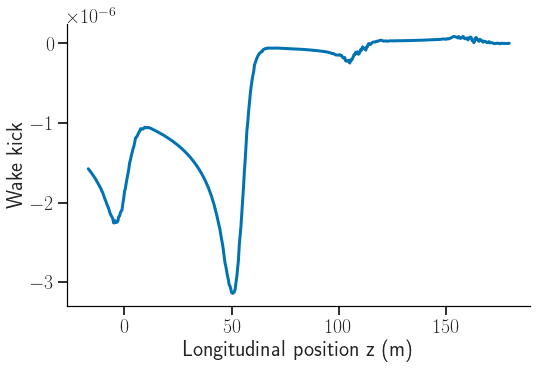

In [199]:
from collections import deque
slice_set = allbunches.get_slices(wake_slicer,
                             statistics=['mean_x', 'mean_y'])
n_turns_wake_max = 1
slice_set_deque = deque([], maxlen=n_turns_wake_max)
slice_set_age_deque = deque([], maxlen=n_turns_wake_max)
slice_set_deque.appendleft(slice_set)
slice_set_age_deque.appendleft(0.)
"""Calculate and apply a dipolar wake kick to bunch.xp
using the given slice_set. Only particles within the slicing
region, i.e particles_within_cuts (defined by the slice_set)
experience the kick.
"""
times_list = [s.convert_to_time(s.z_centers) for s in slice_set_deque]
betas_list = [s.beta for s in slice_set_deque]
moments_list = [s.n_macroparticles_per_slice*s.mean_x for s in slice_set_deque]
dipole_kick_x = wake_field.wake_kicks[0]._accumulate_source_signal(
                                            allbunches,
                                            times_list,
                                            slice_set_age_deque,
                                            moments_list,
                                            betas_list)
z_cuts_range = np.linspace(z_cuts[0],z_cuts[1], 500)
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.plot(z_cuts_range, dipole_kick_x)
ax.set_xlabel('Longitudinal position z (m)')
ax.set_ylabel('Wake kick ')

In [202]:
chromaticity = 0
n_turns = 1
folderall = '/home/vgubaidulin/PhD/Data/CoupledBunch/allbunches'
allslices_monitor = get_slice_monitor(
    folderall, chromaticity, n_turns_slicemonitor, wake_slicer)
chroma = Chromaticity(Qp_x=[chromaticity*Q_x], Qp_y=[chromaticity*Q_y])
trans_map = TransverseMap(s, alpha_x, beta_x, D_x,
                          alpha_y, beta_y, D_y, Q_x, Q_y, [chroma])
trans_one_turn = [m for m in trans_map]
map_ = trans_one_turn + [long_map, wake_field]
for turn in tqdm(range(n_turns)):
    for m_ in map_:
        m_.track(allbunches)
#     allslices_monitor.dump(allbunches)

100%|██████████| 1/1 [00:00<00:00, 22.15it/s]


### All bunches in the longitudinal phase space after tracking

Text(0, 0.5, 'Energy offset $dp/p_0$')

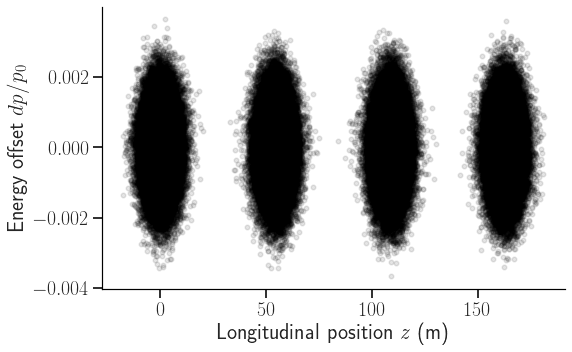

In [203]:
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
# ax.contour(Z, DP, hh, levels=[-150, -40, -20, 20, 40, 150], label=None)
ax.scatter(allbunches.z, allbunches.dp, marker='.', alpha=0.1, color='black')
ax.set_xlabel('Longitudinal position $z$ (m)')
ax.set_ylabel('Energy offset $dp/p_0$')

Text(0, 0.5, 'Particle count')

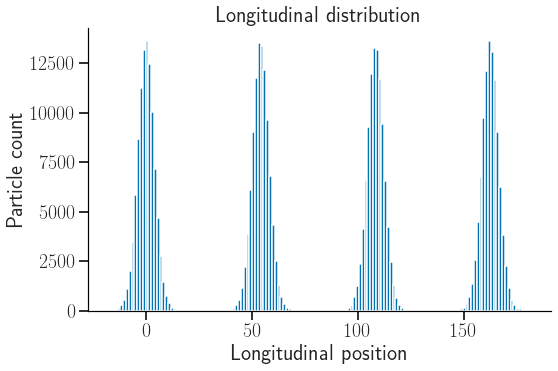

In [204]:
fig, ax = plt.subplots(1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.hist(allbunches.z, bins=150, alpha=1.)
ax.title.set_text('Longitudinal distribution')
ax.set_xlabel('Longitudinal position')
ax.set_ylabel('Particle count')

### Transverse (all particles together)

Text(0, 0.5, 'Horizontal momentum $p_x$')

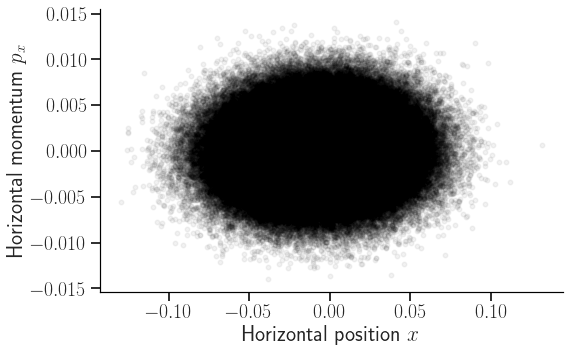

In [205]:
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.scatter(allbunches.x, allbunches.xp, marker='.', alpha=0.05, color='black')
ax.set_xlabel('Horizontal position $x$')
ax.set_ylabel('Horizontal momentum $p_x$')


In [206]:
n_slices_display=100
display_slicer = slicing.UniformBinSlicer(                                     
    n_slices=n_slices_display, z_cuts=z_cuts)
slice_set_display = allbunches.get_slices(display_slicer,
                             statistics=['mean_x', 'mean_y'])
z_cuts_display= np.linspace(z_cuts[0], z_cuts[-1], n_slices_display)


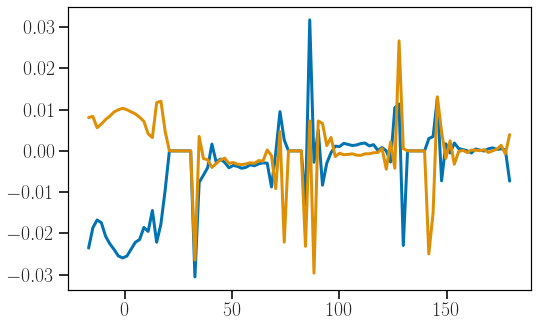

In [207]:
mean_x = slice_set_display.mean_x
mean_y = slice_set_display.mean_y
plt.plot(z_cuts_display, mean_x)
plt.plot(z_cuts_display, mean_y)